# Training with Features

From notebook 14, we now have radio features. From notebook 13, we now have astronomical features and potential host galaxies. It's now time to put all of these together into a set of vectors and train a classifier.

I'll quickly go over the pipeline up to now. First, make sure you have MongoDB running with the `radio` database containing the Radio Galaxy Zoo data. Then, convert all of the raw RGZ classifications into sanitised and nice-to-work-with classifications:

```bash
python -m crowdastro raw_classifications crowdastro-data/processed.db classifications
```

Next, compile the consensus database. For now, I'm only dealing with ATLAS data, so remember to specify the `--atlas` flag.

```bash
python -m crowdastro consensuses crowdastro-data/processed.db classifications atlas_consensuses_raw --atlas
```

We need to generate the training data. If you don't have a Gator cache, it will be generated.

```bash
python -m crowdastro training_data \
    crowdastro-data/processed.db atlas_consensuses_raw \
    gator_cache \
    crowdastro-data/training.h5 \
    --atlas
```

This dumps a file with astronomy features and potential hosts. Then, run 15_cnn to get CNN features (or just use the h5 and json files I already prepared) and run 16_pca to get a PCA matrix.

The pipeline is as follows:

1. Get potential hosts from training.h5.
2. Using the CDFS/ELAIS images, get radio patches around each potential host.
3. Run patches through CNN. Output the second convolutional layer.
4. Run CNN output through PCA.
5. Append astronomy features from training.h5. This is the input data.

In [379]:
import itertools
import sys

import bson
import h5py
import keras.layers
import keras.models
import matplotlib.pyplot
import numpy
import pandas
import sklearn.cross_validation
import sklearn.dummy
import sklearn.linear_model
import sklearn.metrics

sys.path.insert(1, '..')
import crowdastro.data
import crowdastro.show

In [173]:
with pandas.HDFStore('../crowdastro-data/training.h5') as store:
    data = store['data']

data.head()

,subject_id,x,y,flux_ap2_24,flux_ap2_36,flux_ap2_45,flux_ap2_58,flux_ap2_80,is_host
,0,0,0,0,0,0,0,0,0
0,b'54b7f9ee0136916b75000002',32.412434,65.519434,NaN,15.00,14.98,NaN,NaN,0
1,b'54b7f9ee0136916b75000002',161.776174,130.278864,NaN,30.31,20.21,NaN,NaN,0
2,b'54b7f9ee0136916b75000002',101.349871,100.381640,NaN,104.39,79.63,56.32,NaN,1
3,b'54b7f9ee0136916b75000002',54.028687,186.482581,NaN,144.58,101.51,72.96,80.26,0
4,b'54b7f9ee0136916b75000002',102.648851,71.261272,NaN,11.36,8.96,NaN,NaN,0


We'll just look at a small number of potential hosts for now. I'll have to do batches to scale this up and I just want to check it works for now.

In [316]:
n = 5000

# I'm gathering up the radio patches first so I can run them through the CNN at the same time
# as one big matrix operation. In principle this would run on the GPU.
radio_patches = numpy.zeros((n, 80, 80))
labels = numpy.zeros((n,))

radius = 40
padding = 150

for idx, row in data.head(n).iterrows():
    sid = bson.objectid.ObjectId(row['subject_id'][0].decode('ascii'))
    x = row['x'][0]
    y = row['y'][0]
    label = row['is_host'][0]
    
    labels[idx] = label
    
    subject = crowdastro.data.db.radio_subjects.find_one({'_id': sid})
    radio = crowdastro.data.get_radio(subject, size='5x5')
    patch = radio[x - radius + padding : x + radius + padding, y - radius + padding : y + radius + padding]
    radio_patches[idx, :] = patch

K:\Languages\Anaconda3\lib\site-packages\astropy\io\fits\util.py:578: UserWarning: Could not find appropriate MS Visual C Runtime library or library is corrupt/misconfigured; cannot determine whether your file object was opened in append mode.  Please consider using a file object opened in write mode instead.
  'Could not find appropriate MS Visual C Runtime '
K:\Languages\Anaconda3\lib\site-packages\ipykernel\__main__.py:21: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [254]:
# Load the CNN.

with open('../crowdastro-data/cnn_model_2.json', 'r') as f:
    cnn = keras.models.model_from_json(f.read())

cnn.load_weights('../crowdastro-data/cnn_weights_2.h5')

In [255]:
cnn.layers = cnn.layers[:5]  # Pop the layers after the second convolution's activation.
cnn.add(keras.layers.Flatten())

In [256]:
cnn.compile(optimizer='sgd', loss='mse')  # I don't actually care about the optimiser or loss.

In [263]:
# Load the PCA.
with h5py.File('../crowdastro-data/pca.h5') as f:
    pca = f['conv_2'][:]

In [318]:
# Find the radio features.
radio_features = cnn.predict(radio_patches.reshape(n, 1, 80, 80)) @ pca.T

In [320]:
# Add on the astronomy features.
features = numpy.hstack([radio_features, data.ix[:n-1, 'flux_ap2_24':'flux_ap2_80'].as_matrix()])
features = numpy.nan_to_num(features)

In [321]:
# Split into training and testing data.
xs_train, xs_test, ts_train, ts_test = sklearn.cross_validation.train_test_split(features, labels, test_size=0.2)

In [322]:
# Classify!
lr = sklearn.linear_model.LogisticRegression(class_weight='balanced')
lr.fit(xs_train, ts_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [323]:
lr.score(xs_test, ts_test)

0.83399999999999996

In [324]:
sklearn.metrics.confusion_matrix(ts_test, lr.predict(xs_test), [0, 1])

array([[811, 129],
       [ 37,  23]])

So we get ~84% accuracy on just predicting labels. Let's compare to a random classifier.

In [326]:
dc = sklearn.dummy.DummyClassifier(strategy='stratified')
dc.fit(xs_train, ts_train)

DummyClassifier(constant=None, random_state=None, strategy='stratified')

In [327]:
dc.score(xs_test, ts_test)

0.88300000000000001

A stratified random classifier gets 88% accuracy, which doesn't look good for our logistic regression! 

I am curious as to whether we can do better if we're considering the full problem, i.e. we know that exactly one potential host is the true host. Note that I'm ignoring the problem of multiple radio emitters for now. Let's try that: We'll get a subject, find the potential hosts, get their patches, and use the logistic regression and dummy classifiers to predict all the associated probabilities, and hence find the radio emitter. I'll only look at subjects not in the first `n` potential hosts, else we'd overlap with the training data.

To get a feel for how the predictor works, I'll try colour-coding potential hosts based on how likely they are to be the true host. To do *that*, I'll softmax the scores.

In [376]:
def softmax(x):
    exp = numpy.exp(x)
    return exp / numpy.sum(exp, axis=0)

In [330]:
subject_ids = set()
for idx, row in data.ix[n:n * 2].iterrows():
    sid = row['subject_id'][0]
    subject_ids.add(sid)

K:\Languages\Anaconda3\lib\site-packages\astropy\io\fits\util.py:578: UserWarning: Could not find appropriate MS Visual C Runtime library or library is corrupt/misconfigured; cannot determine whether your file object was opened in append mode.  Please consider using a file object opened in write mode instead.
  'Could not find appropriate MS Visual C Runtime '
K:\Languages\Anaconda3\lib\site-packages\ipykernel\__main__.py:11: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


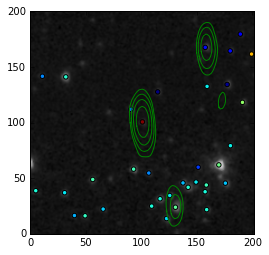

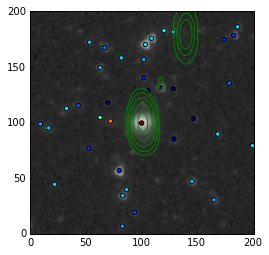

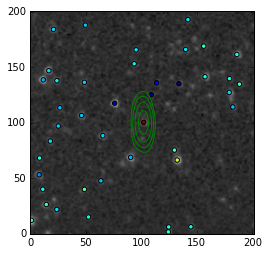

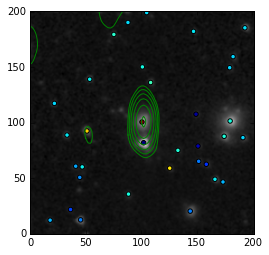

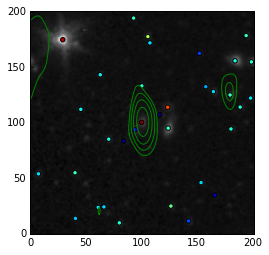

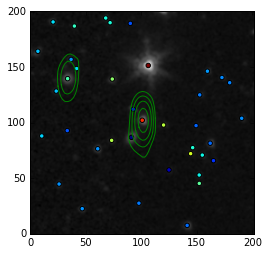

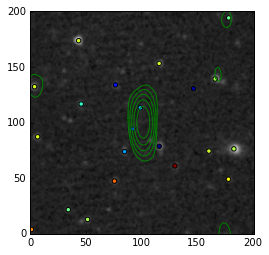

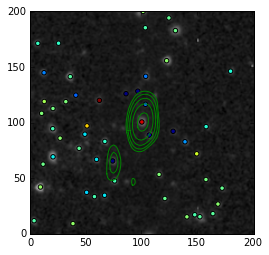

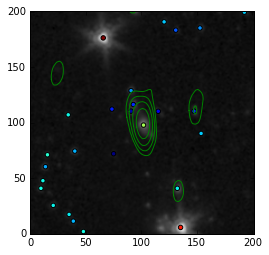

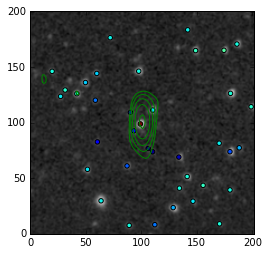

In [382]:
for subject_id in itertools.islice(subject_ids, 0, 10):
    # Pandas *really* doesn't like fancy indexing against string comparisons.
    indices = (data['subject_id'] == subject_id).as_matrix().reshape(-1)
    potential_hosts = numpy.nan_to_num(data.as_matrix()[indices][:, 1:-1].astype(float))
    
    subject = crowdastro.data.db.radio_subjects.find_one({'_id': bson.objectid.ObjectId(subject_id.decode('ascii'))})
    radio = crowdastro.data.get_radio(subject, size='5x5')
    
    radio_patches = numpy.zeros((len(potential_hosts), 1, radius * 2, radius * 2))
    for index, (x, y, *astro) in enumerate(potential_hosts):
        patch = radio[x - radius + padding : x + radius + padding, y - radius + padding : y + radius + padding]
        radio_patches[index, 0, :] = patch
    
    radio_features = cnn.predict(radio_patches) @ pca.T
    astro_features = potential_hosts[:, 2:]
    features = numpy.hstack([radio_features, astro_features])
    
    scores = lr.predict_proba(features)[:, 1].T
    probs = softmax(scores)
    
    crowdastro.show.subject(subject)
    matplotlib.pyplot.scatter(potential_hosts[:, 0], potential_hosts[:, 1], c=probs)
    matplotlib.pyplot.show()

This is quite interesting! Lots of points (blue) are not really considered, and sometimes there are a few candidates (red). These usually look pretty reasonable, but it also seems a lot like the predictor is just looking for bright things.

Let's try and get an accuracy out. There is still the problem of multiple radio sources, so I'll just say that if the predictor hits *any* true host, that's a hit.

In [396]:
hits = 0
attempts = 0

for subject_id in subject_ids:
    indices = (data['subject_id'] == subject_id).as_matrix().reshape(-1)
    potential_hosts = numpy.nan_to_num(data.as_matrix()[indices][:, 1:-1].astype(float))
    labels = numpy.nan_to_num(data.as_matrix()[indices][:, -1].astype(bool))
    
    subject = crowdastro.data.db.radio_subjects.find_one({'_id': bson.objectid.ObjectId(subject_id.decode('ascii'))})
    radio = crowdastro.data.get_radio(subject, size='5x5')
    
    radio_patches = numpy.zeros((len(potential_hosts), 1, radius * 2, radius * 2))
    for index, (x, y, *astro) in enumerate(potential_hosts):
        patch = radio[x - radius + padding : x + radius + padding, y - radius + padding : y + radius + padding]
        radio_patches[index, 0, :] = patch
    
    radio_features = cnn.predict(radio_patches) @ pca.T
    astro_features = potential_hosts[:, 2:]
    features = numpy.hstack([radio_features, astro_features])
    
    scores = lr.predict_proba(features)[:, 1].reshape(-1)
    predicted_host = scores.argmax()
    if labels[predicted_host]:
        hits += 1
    attempts += 1

K:\Languages\Anaconda3\lib\site-packages\astropy\io\fits\util.py:578: UserWarning: Could not find appropriate MS Visual C Runtime library or library is corrupt/misconfigured; cannot determine whether your file object was opened in append mode.  Please consider using a file object opened in write mode instead.
  'Could not find appropriate MS Visual C Runtime '
K:\Languages\Anaconda3\lib\site-packages\ipykernel\__main__.py:14: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [397]:
print('Accuracy: {:.02%}'.format(hits / attempts))

Accuracy: 62.32%


Against a random classifier...

In [398]:
hits = 0
attempts = 0

for subject_id in subject_ids:
    indices = (data['subject_id'] == subject_id).as_matrix().reshape(-1)
    potential_hosts = numpy.nan_to_num(data.as_matrix()[indices][:, 1:-1].astype(float))
    labels = numpy.nan_to_num(data.as_matrix()[indices][:, -1].astype(bool))
    
    subject = crowdastro.data.db.radio_subjects.find_one({'_id': bson.objectid.ObjectId(subject_id.decode('ascii'))})
    radio = crowdastro.data.get_radio(subject, size='5x5')
    
    radio_patches = numpy.zeros((len(potential_hosts), 1, radius * 2, radius * 2))
    for index, (x, y, *astro) in enumerate(potential_hosts):
        patch = radio[x - radius + padding : x + radius + padding, y - radius + padding : y + radius + padding]
        radio_patches[index, 0, :] = patch
    
    radio_features = cnn.predict(radio_patches) @ pca.T
    astro_features = potential_hosts[:, 2:]
    features = numpy.hstack([radio_features, astro_features])
    
    scores = dc.predict_proba(features)[:, 1].reshape(-1)
    predicted_host = scores.argmax()
    if labels[predicted_host]:
        hits += 1
    attempts += 1

K:\Languages\Anaconda3\lib\site-packages\astropy\io\fits\util.py:578: UserWarning: Could not find appropriate MS Visual C Runtime library or library is corrupt/misconfigured; cannot determine whether your file object was opened in append mode.  Please consider using a file object opened in write mode instead.
  'Could not find appropriate MS Visual C Runtime '
K:\Languages\Anaconda3\lib\site-packages\ipykernel\__main__.py:14: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [399]:
print('Accuracy: {:.02%}'.format(hits / attempts))

Accuracy: 7.97%


It would also be useful to know what the classifier considers "hard" to classify. I think an entropy approach might work (though there are problems with this...). Let's find the highest-entropy subject.

In [400]:
max_entropy = float('-inf')
max_subject = None

for subject_id in subject_ids:
    indices = (data['subject_id'] == subject_id).as_matrix().reshape(-1)
    potential_hosts = numpy.nan_to_num(data.as_matrix()[indices][:, 1:-1].astype(float))
    labels = numpy.nan_to_num(data.as_matrix()[indices][:, -1].astype(bool))
    
    subject = crowdastro.data.db.radio_subjects.find_one({'_id': bson.objectid.ObjectId(subject_id.decode('ascii'))})
    radio = crowdastro.data.get_radio(subject, size='5x5')
    
    radio_patches = numpy.zeros((len(potential_hosts), 1, radius * 2, radius * 2))
    for index, (x, y, *astro) in enumerate(potential_hosts):
        patch = radio[x - radius + padding : x + radius + padding, y - radius + padding : y + radius + padding]
        radio_patches[index, 0, :] = patch
    
    radio_features = cnn.predict(radio_patches) @ pca.T
    astro_features = potential_hosts[:, 2:]
    features = numpy.hstack([radio_features, astro_features])
    
    probabilities = softmax(lr.predict_proba(features)[:, 1].reshape(-1))
    entropy = -(probabilities * numpy.log(probabilities)).sum()
    
    if entropy > max_entropy:
        max_entropy = entropy
        max_subject = subject

K:\Languages\Anaconda3\lib\site-packages\astropy\io\fits\util.py:578: UserWarning: Could not find appropriate MS Visual C Runtime library or library is corrupt/misconfigured; cannot determine whether your file object was opened in append mode.  Please consider using a file object opened in write mode instead.
  'Could not find appropriate MS Visual C Runtime '
K:\Languages\Anaconda3\lib\site-packages\ipykernel\__main__.py:14: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


K:\Languages\Anaconda3\lib\site-packages\astropy\io\fits\util.py:578: UserWarning: Could not find appropriate MS Visual C Runtime library or library is corrupt/misconfigured; cannot determine whether your file object was opened in append mode.  Please consider using a file object opened in write mode instead.
  'Could not find appropriate MS Visual C Runtime '


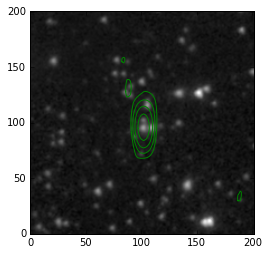

In [401]:
crowdastro.show.subject(max_subject)

K:\Languages\Anaconda3\lib\site-packages\astropy\io\fits\util.py:578: UserWarning: Could not find appropriate MS Visual C Runtime library or library is corrupt/misconfigured; cannot determine whether your file object was opened in append mode.  Please consider using a file object opened in write mode instead.
  'Could not find appropriate MS Visual C Runtime '
K:\Languages\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


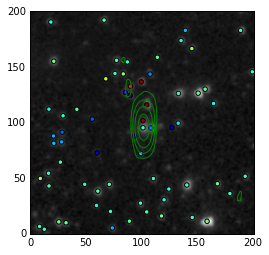

In [402]:
indices = (data['subject_id'] == str(max_subject['_id']).encode('ascii')).as_matrix().reshape(-1)
potential_hosts = numpy.nan_to_num(data.as_matrix()[indices][:, 1:-1].astype(float))

subject = max_subject
radio = crowdastro.data.get_radio(subject, size='5x5')

radio_patches = numpy.zeros((len(potential_hosts), 1, radius * 2, radius * 2))
for index, (x, y, *astro) in enumerate(potential_hosts):
    patch = radio[x - radius + padding : x + radius + padding, y - radius + padding : y + radius + padding]
    radio_patches[index, 0, :] = patch

radio_features = cnn.predict(radio_patches) @ pca.T
astro_features = potential_hosts[:, 2:]
features = numpy.hstack([radio_features, astro_features])

scores = lr.predict_proba(features)[:, 1].T
probs = softmax(scores)

crowdastro.show.subject(subject)
matplotlib.pyplot.scatter(potential_hosts[:, 0], potential_hosts[:, 1], c=probs)
matplotlib.pyplot.show()

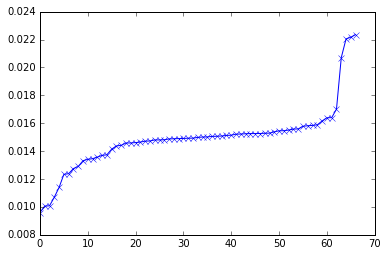

In [411]:
matplotlib.pyplot.plot(sorted(probs), marker='x')